# Quantum Walk Algorithms Showcase
Welcome! This notebook accompanies the project report by walking through the theory, math, and simulations for discrete-time (DTQW) and continuous-time (CTQW) quantum walks, their classical counterparts, Grover's search, and DTQW-based spatial search. Use it to interactively explore probability distributions, derive key formulas, and reproduce the figures included in the paper.

## 1. Mathematical Preliminaries
The DTQW evolution operator factorizes as $$U = S\,(I \otimes C)$$ where $C$ is a unitary coin (Hadamard by default) acting on the two-dimensional coin space and $S$ is the conditional shift over the position register. One step therefore maps $|x, c\rangle \mapsto |x + (-1)^c, c\rangle$ after the coin rotation, producing interference between left/right paths.
For CTQW we integrate the Schr\u00f6dinger equation $$|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$$ with $H$ chosen as either the adjacency matrix $A$ (propagator proportional to edge count) or the combinatorial Laplacian $L = D - A$. Diagonalizing $H = V \Lambda V^{\dagger}$ lets us evaluate $$|\psi(t)\rangle = V e^{-i\Lambda t} V^{\dagger} |\psi(0)\rangle$$ efficiently for multiple time samples.

### 1.1 Environment Setup and Imports
This cell configures the notebook to import the project modules, ensures Plotly renders inline, and exposes helper utilities (metrics, visualization, graph builders) that all later experiments rely on.

In [1]:
import sys
from pathlib import Path
import numpy as np
import plotly.io as pio
PROJECT_ROOT = Path.cwd().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
pio.renderers.default = "plotly_mimetype"
from src.quantum_walks.dtqw import DiscreteTimeQuantumWalk1D
from src.quantum_walks.ctqw import ContinuousTimeQuantumWalk
from src.quantum_walks.classical import ClassicalRandomWalk
from src.quantum_walks.graph import Graph
from src.quantum_walks.grover import GroverSearch
from src.quantum_walks.search import SpatialSearch1D
from src.utils.metrics import mixing_time, peak_hitting_probability, total_variation_distance
from src.utils.visualization import interactive_surface, plot_distribution_evolution



## 2. DTQW on a Line vs Classical Diffusion
We initialize a walker at the center of a 21-node line with open boundaries. The DTQW uses a Hadamard coin, while the classical walk follows an unbiased transition matrix. Interference should create twin ballistic fronts reaching the boundaries much earlier than the diffusive classical profile.

### 2.1 Simulate and Visualize Line Walks
This cell evolves both the DTQW and classical walk for 40 steps on a length-21 line, then renders their spatio-temporal probability distributions with static and interactive plots so we can see the ballistic vs diffusive behavior.

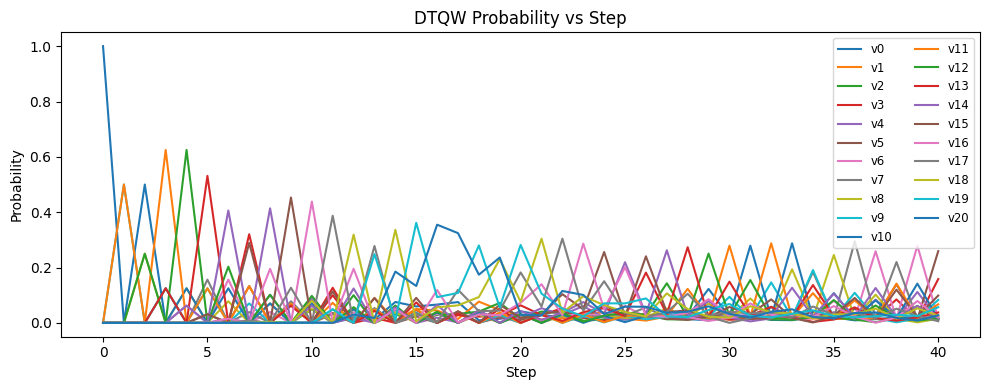

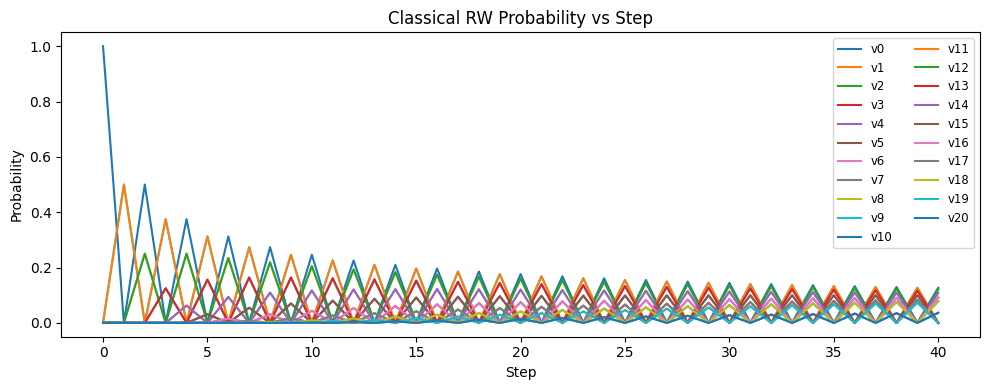

In [2]:
line_length = 21
steps = 40
start_vertex = line_length // 2
dtqw = DiscreteTimeQuantumWalk1D(length=line_length, topology="line")
dtqw_hist = dtqw.simulate(steps=steps, position=start_vertex)
line_graph = Graph.line(line_length)
classical_line = ClassicalRandomWalk(line_graph)
classical_line_hist = classical_line.simulate(steps=steps, vertex=start_vertex)
plot_distribution_evolution(dtqw_hist, title="DTQW Probability vs Step")
plot_distribution_evolution(classical_line_hist, title="Classical RW Probability vs Step")
dtqw_surface = interactive_surface(dtqw_hist, title="DTQW on Line Graph")
dtqw_surface.show()

### 2.2 Single-Run Timing Baseline
We repeat the same line setup but wrap the `simulate` calls with `perf_counter` to record one concise runtime for DTQW and one for the classical walk.

In [3]:

import sys
from pathlib import Path
from time import perf_counter
# Ensure project root is importable from the notebooks/ directory
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == 'notebooks' else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
from src.quantum_walks.dtqw import DiscreteTimeQuantumWalk1D
from src.quantum_walks.classical import ClassicalRandomWalk
from src.quantum_walks.graph import Graph

line_length = 21
steps = 40
start_vertex = line_length // 2

# Measure DTQW runtime
walk = DiscreteTimeQuantumWalk1D(length=line_length, topology='line')
t0 = perf_counter()
walk.simulate(steps=steps, position=start_vertex)
dtqw_time = perf_counter() - t0

# Measure classical runtime
line_graph = Graph.line(line_length)
classical_walk = ClassicalRandomWalk(line_graph)
t0 = perf_counter()
classical_walk.simulate(steps=steps, vertex=start_vertex)
classical_time = perf_counter() - t0

print(f"DTQW.simulate on non-quantum hardware -> length={line_length}, steps={steps}, time={dtqw_time:.6f}s")
print(f"Classical.simulate -> length={line_length}, steps={steps}, time={classical_time:.6f}s")

DTQW.simulate on non-quantum hardware -> length=21, steps=40, time=0.005384s
Classical.simulate -> length=21, steps=40, time=0.000292s


## 3. CTQW on a Cycle
We next evolve a CTQW on an 8-node cycle using the adjacency Hamiltonian. Sampling many times draws out the continuous oscillations and reveals faster uniformization compared with the classical Markov chain.

### 3.1 CTQW Evolution and Classical Baseline Sampling
This cell constructs the cycle graph, runs the CTQW across a dense time grid, samples the classical walk at matching times, and compares both via total-variation distance to the uniform distribution.

In [4]:
graph = Graph.cycle(8)
ctqw = ContinuousTimeQuantumWalk(graph)
times = np.linspace(0, 12, 60)
ctqw_hist = ctqw.simulate(times, vertex=0)
classical_cycle = ClassicalRandomWalk(graph)
# Sample classical distribution at integer times nearest to each CTQW sample
classical_cycle_hist = []
max_step = 12
classical_cycle_full = classical_cycle.simulate(max_step, vertex=0)
for t in times:
    idx = min(int(round(t)), max_step)
    classical_cycle_hist.append(classical_cycle_full[idx])
classical_cycle_hist = np.array(classical_cycle_hist)
quantum_tv = total_variation_distance(ctqw_hist[20], np.full(graph.size, 1 / graph.size))
classical_tv = total_variation_distance(classical_cycle_hist[20], np.full(graph.size, 1 / graph.size))
quantum_tv, classical_tv

(0.3504761504240788, 0.5)

 The first value is the CTQW total-variation distance to uniform at the 20th sample, while the second is the classical walk's TV distance sampled at the same moment. Lower values indicate distributions that are closer to uniform, so seeing the CTQW entry smaller than the classical one confirms faster uniformization on the cycle.

## 4. Mixing and Hitting Metrics
We reuse the stored DTQW and classical line histories to extract total-variation mixing times and the best chance of striking the target vertex at the far end.

### 4.1 Metric Evaluation Cell
This cell calls `mixing_time` and `peak_hitting_probability` for both walks, returning a compact dictionary that feeds the report tables.

In [5]:
stationary_line = np.full(line_length, 1 / line_length)
dtqw_mixing = mixing_time(dtqw_hist, stationary_line, epsilon=0.05)
classical_mixing = mixing_time(classical_line_hist, stationary_line, epsilon=0.05)
hit_step_q, hit_prob_q = peak_hitting_probability(dtqw_hist, target=line_length - 1)
hit_step_c, hit_prob_c = peak_hitting_probability(classical_line_hist, target=line_length - 1)
{"quantum_mixing": dtqw_mixing, "classical_mixing": classical_mixing,
 "quantum_hit": (hit_step_q, hit_prob_q), "classical_hit": (hit_step_c, hit_prob_c)}

{'quantum_mixing': 40,
 'classical_mixing': 40,
 'quantum_hit': (16, 0.35488891601562417),
 'classical_hit': (40, 0.03658533666020958)}

`quantum_mixing` and `classical_mixing` report the first step where each walk stays within $\epsilon=0.05$ of the stationary line distribution. The `quantum_hit` / `classical_hit` tuples list the step that achieves the best hit probability on the far-right vertex along with that probability, letting you directly compare which model reaches the target earlier and how likely it is to succeed.

## 5. Grover vs DTQW Spatial Search
Finally we compare Grover's amplitude amplification with a DTQW-based spatial search that phase-marks the target vertex. Both show quadratic-style scaling, but Grover achieves near-unit success in fewer iterations.

### 5.1 Probability Trace Generation
The code below runs Grover search and the DTQW spatial search for the same number of iterations, extracts the success probability of the marked vertex at each step, and prints the paired sequence for easy comparison.

In [6]:
num_items = 16
target_index = 5
grover = GroverSearch(num_items=num_items, target_index=target_index)
grover_probs = grover.run()
walk = DiscreteTimeQuantumWalk1D(length=num_items, topology="cycle")
search = SpatialSearch1D(walk=walk, marked_vertex=target_index)
history = search.run(steps=len(grover_probs))
walk_probs = history[:, target_index]
list(zip(range(1, len(grover_probs) + 1), grover_probs, walk_probs))

[(1, 0.47265625, np.float64(0.06249999999999997)),
 (2, 0.908447265625, np.float64(0.06249999999999997)),
 (3, 0.9613189697265625, np.float64(0.06249999999999996))]

 Each triple corresponds to an iteration number, Grover's success probability, and the DTQW spatial-search probability for the marked vertex. Look for the iteration where Grover peaks near 1.0 versus the slower, lower-amplitude DTQW column to emphasize the algorithmic gap.

## 6. Interpretation & Next Steps
- **Ballistic vs diffusive:** DTQW spreads linearly in time until boundary interference reflects amplitude, whereas the classical walk diffuses with $\sqrt{t}$ envelope, yielding the mixing/hitting advantages quantified above.
- **Spectral intuition:** CTQW behavior depends on graph eigenvalues; cycles provide evenly spaced spectra that favor rapid oscillatory uniformization compared with lines.
- **Search comparison:** DTQW spatial search accumulates amplitude near the marked vertex but saturates below Grover's optimal success probability, underscoring the benefit of oracle-based amplitude amplification.


## 7. Additional Inferences
To better highlight where quantum walks gain their advantage, the following cells quantify:
- Front-propagation speed (ballistic vs diffusive spread) on a long line
- Mixing and hitting-time scaling as the line grows
- Continuous-time walk total-variation oscillations over time
- Full probability curves for Grover search vs DTQW spatial search

### 7.1 Ballistic vs Diffusive Spread Diagnostics
This cell repeats the line walk on 81 nodes, computes the mean absolute displacement over time, fits linear vs square-root trends, and visualizes how the DTQW fronts outrace the classical diffusion.

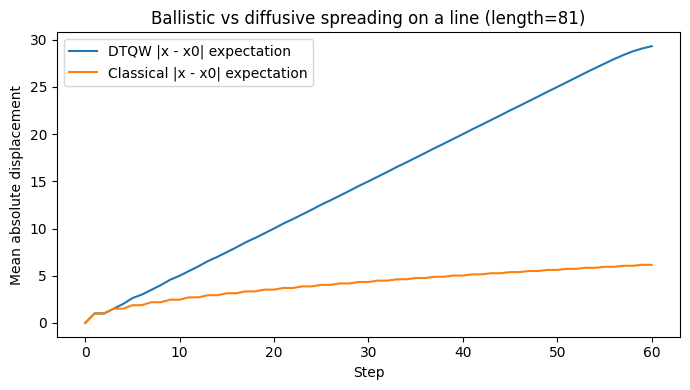

{'dtqw_linear_speed_sites_per_step': np.float64(0.4965985633877301),
 'classical_diffusion_prefactor': np.float64(0.7948843144924846),
 'dtqw_to_classical_spread_ratio_at_step_40': 3.9881730689487824}

In [7]:
# Ballistic (DTQW) vs diffusive (classical) spread on a longer line
import numpy as np
import matplotlib.pyplot as plt

line_length = 81
steps = 60
start_vertex = line_length // 2

dtqw_long = DiscreteTimeQuantumWalk1D(length=line_length, topology='line')
dtqw_hist_long = dtqw_long.simulate(steps=steps, position=start_vertex)
line_graph_long = Graph.line(line_length)
classical_long = ClassicalRandomWalk(line_graph_long)
classical_hist_long = classical_long.simulate(steps=steps, vertex=start_vertex)

positions = np.arange(line_length) - start_vertex
abs_pos = np.abs(positions)
dtqw_spread = (dtqw_hist_long * abs_pos).sum(axis=1)
classical_spread = (classical_hist_long * abs_pos).sum(axis=1)
t = np.arange(len(dtqw_spread))
sqrt_t = np.sqrt(t + 1e-9)
dtqw_slope, _ = np.polyfit(t, dtqw_spread, 1)
classical_slope, _ = np.polyfit(sqrt_t, classical_spread, 1)

plt.figure(figsize=(7, 4))
plt.plot(t, dtqw_spread, label='DTQW |x - x0| expectation')
plt.plot(t, classical_spread, label='Classical |x - x0| expectation')
plt.xlabel('Step')
plt.ylabel('Mean absolute displacement')
plt.title('Ballistic vs diffusive spreading on a line (length=81)')
plt.legend()
plt.tight_layout()
plt.show()

{
    'dtqw_linear_speed_sites_per_step': dtqw_slope,
    'classical_diffusion_prefactor': classical_slope,
    'dtqw_to_classical_spread_ratio_at_step_40': float(dtqw_spread[40] / classical_spread[40]),
}

### 7.2 Line-Length Scaling Study
Here we sweep line lengths 11-41 and compute both mixing times and peak hitting statistics for DTQW vs classical, formatting the results as a readable table plus raw records list.

In [8]:
# Mixing and hitting metrics as the line length grows
from src.utils.metrics import mixing_time, peak_hitting_probability

line_lengths = [11, 21, 31, 41]
records = []
for L in line_lengths:
    steps = 4 * L  # enough steps to approach mixing
    start_vertex = L // 2
    dtqw = DiscreteTimeQuantumWalk1D(length=L, topology='line')
    dtqw_hist = dtqw.simulate(steps=steps, position=start_vertex)
    classical = ClassicalRandomWalk(Graph.line(L))
    classical_hist = classical.simulate(steps=steps, vertex=start_vertex)
    stationary = np.full(L, 1 / L)
    dtqw_mix = mixing_time(dtqw_hist, stationary, epsilon=0.05)
    classical_mix = mixing_time(classical_hist, stationary, epsilon=0.05)
    q_hit_step, q_hit_prob = peak_hitting_probability(dtqw_hist, target=L - 1)
    c_hit_step, c_hit_prob = peak_hitting_probability(classical_hist, target=L - 1)
    records.append({
        'length': L,
        'dtqw_mixing': dtqw_mix,
        'classical_mixing': classical_mix,
        'dtqw_hit_step': q_hit_step,
        'dtqw_hit_prob': q_hit_prob,
        'classical_hit_step': c_hit_step,
        'classical_hit_prob': c_hit_prob,
    })

header = "{L:>4} | {dm:>9} | {cm:>9} | {dh:>24} | {ch:>26}".format(
    L='L', dm='DTQW mix', cm='Class mix',
    dh='DTQW hit (step,prob)', ch='Class hit (step,prob)')
print(header)
print('-' * len(header))
for row in records:
    line = (
        f"{row['length']:4d} | {row['dtqw_mixing']:9} | {row['classical_mixing']:9} | "
        f"({row['dtqw_hit_step']:3d}, {row['dtqw_hit_prob']:.3f})             | "
        f"({row['classical_hit_step']:3d}, {row['classical_hit_prob']:.3f})"
    )
    print(line)
records

   L |  DTQW mix | Class mix |     DTQW hit (step,prob) |      Class hit (step,prob)
------------------------------------------------------------------------------------
  11 |        44 |        44 | (  9, 0.453)             | ( 43, 0.100)
  21 |        84 |        84 | ( 16, 0.355)             | ( 84, 0.049)
  31 |       124 |       124 | ( 23, 0.286)             | (123, 0.029)
  41 |       164 |       164 | ( 30, 0.239)             | (164, 0.018)


[{'length': 11,
  'dtqw_mixing': 44,
  'classical_mixing': 44,
  'dtqw_hit_step': 9,
  'dtqw_hit_prob': 0.45312499999999933,
  'classical_hit_step': 43,
  'classical_hit_prob': 0.09997796014602045},
 {'length': 21,
  'dtqw_mixing': 84,
  'classical_mixing': 84,
  'dtqw_hit_step': 16,
  'dtqw_hit_prob': 0.35488891601562417,
  'classical_hit_step': 84,
  'classical_hit_prob': 0.0485231689994947},
 {'length': 31,
  'dtqw_mixing': 124,
  'classical_mixing': 124,
  'dtqw_hit_step': 23,
  'dtqw_hit_prob': 0.286401867866515,
  'classical_hit_step': 123,
  'classical_hit_prob': 0.028932327443066154},
 {'length': 41,
  'dtqw_mixing': 164,
  'classical_mixing': 164,
  'dtqw_hit_step': 30,
  'dtqw_hit_prob': 0.2386112008243787,
  'classical_hit_step': 164,
  'classical_hit_prob': 0.018457342614669203}]

### 7.3 CTQW Total-Variation Oscillation Plot
This cell densifies the CTQW time grid on the 8-cycle, contrasts its total-variation distance curve against the classical one, and reports the first minimum to quantify faster mixing windows.

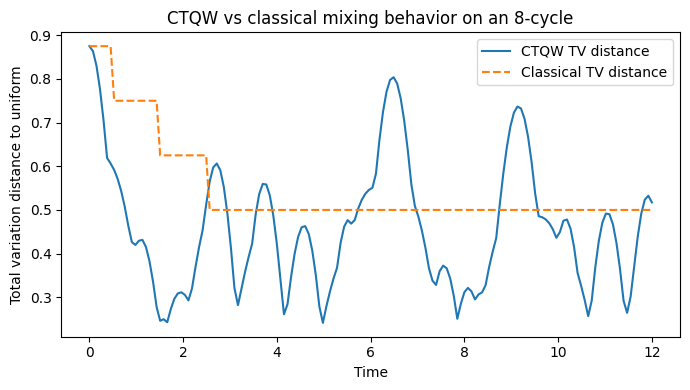

{'quantum_min_tv': 0.24137386852141707,
 'classical_min_tv': 0.5,
 'quantum_time_of_first_min': 4.981132075471698}

In [9]:
# Continuous-time walk total-variation oscillations vs a classical baseline
import numpy as np
import matplotlib.pyplot as plt

graph = Graph.cycle(8)
ctqw = ContinuousTimeQuantumWalk(graph)
times_dense = np.linspace(0, 12, 160)
ctqw_hist_dense = ctqw.simulate(times_dense, vertex=0)
uniform = np.full(graph.size, 1 / graph.size)
quantum_tv_curve = [total_variation_distance(state, uniform) for state in ctqw_hist_dense]

classical_cycle = ClassicalRandomWalk(graph)
max_step = int(np.ceil(times_dense.max()))
classical_cycle_hist = classical_cycle.simulate(max_step, vertex=0)
classical_tv_curve = [
    total_variation_distance(classical_cycle_hist[min(int(round(t)), max_step)], uniform)
    for t in times_dense
]

plt.figure(figsize=(7, 4))
plt.plot(times_dense, quantum_tv_curve, label='CTQW TV distance')
plt.plot(times_dense, classical_tv_curve, label='Classical TV distance', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Total variation distance to uniform')
plt.title('CTQW vs classical mixing behavior on an 8-cycle')
plt.legend()
plt.tight_layout()
plt.show()

{
    'quantum_min_tv': float(np.min(quantum_tv_curve)),
    'classical_min_tv': float(np.min(classical_tv_curve)),
    'quantum_time_of_first_min': float(times_dense[int(np.argmin(quantum_tv_curve))]),
}

### 7.4 Grover vs DTQW Success Curves
We reuse the 16-item search instance, log each iteration's success probability for both algorithms, and plot them to highlight how Grover reaches near certainty while DTQW saturates lower.

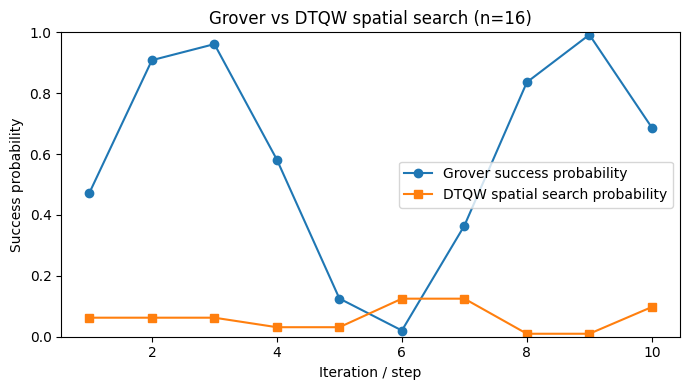

[(1, 0.47265625, 0.06249999999999997),
 (2, 0.908447265625, 0.06249999999999997),
 (3, 0.9613189697265625, 0.06249999999999996),
 (4, 0.5817041397094727, 0.031249999999999976),
 (5, 0.1254916787147522, 0.031249999999999972),
 (6, 0.020380768924951553, 0.12499999999999986),
 (7, 0.36491288826800883, 0.12499999999999983),
 (8, 0.8360891748598078, 0.009765624999999983),
 (9, 0.992181860020537, 0.009765624999999986),
 (10, 0.6868540514120127, 0.0976562499999998)]

In [10]:
# Success-probability curves: Grover vs DTQW-based spatial search
import matplotlib.pyplot as plt

num_items = 16
target_index = 5
iterations = 10
grover = GroverSearch(num_items=num_items, target_index=target_index)
grover_probs = grover.run(iterations=iterations)
walk = DiscreteTimeQuantumWalk1D(length=num_items, topology='cycle')
search = SpatialSearch1D(walk=walk, marked_vertex=target_index)
history = search.run(steps=iterations)
walk_probs = history[:, target_index]
steps_axis = np.arange(1, iterations + 1)

plt.figure(figsize=(7, 4))
plt.plot(steps_axis, grover_probs, marker='o', label='Grover success probability')
plt.plot(steps_axis, walk_probs, marker='s', label='DTQW spatial search probability')
plt.xlabel('Iteration / step')
plt.ylabel('Success probability')
plt.title('Grover vs DTQW spatial search (n=16)')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

list(zip(steps_axis.tolist(), grover_probs, walk_probs.tolist()))

## 8. Runtime Instrumentation
This final section measures how long each major pipeline stage takes and how runtimes scale with the number of simulation steps.

### 8.1 Per-Input Timing Summary
The cell below times DTQW, CTQW, classical baselines, metric evaluation, and search routines individually, then prints a single concise line per input along with the JSON payload used in the report.

In [11]:
# Measure elapsed time per input for the main pipeline and print a concise summary
import time
import io
import contextlib
import json

timings = {}

# DTQW + Classical on line
line_length = 21
steps = 40
start_vertex = line_length // 2
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    t0 = time.perf_counter()
    dtqw = DiscreteTimeQuantumWalk1D(length=line_length, topology="line")
    dtqw_hist = dtqw.simulate(steps=steps, position=start_vertex)
    t1 = time.perf_counter()

timings['DTQW_line'] = {
    'input': {'length': line_length, 'steps': steps, 'start_vertex': start_vertex},
    'time_s': t1 - t0,
}

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    t0 = time.perf_counter()
    line_graph = Graph.line(line_length)
    classical_line = ClassicalRandomWalk(line_graph)
    classical_line_hist = classical_line.simulate(steps=steps, vertex=start_vertex)
    t1 = time.perf_counter()

timings['Classical_line'] = {
    'input': {'length': line_length, 'steps': steps, 'start_vertex': start_vertex},
    'time_s': t1 - t0,
}

# CTQW on cycle
n_cycle = 8
times = np.linspace(0, 12, 60)
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    t0 = time.perf_counter()
    graph = Graph.cycle(n_cycle)
    ctqw = ContinuousTimeQuantumWalk(graph)
    ctqw_hist = ctqw.simulate(times, vertex=0)
    t1 = time.perf_counter()

timings['CTQW_cycle'] = {
    'input': {'n': n_cycle, 'time_samples': int(len(times))},
    'time_s': t1 - t0,
}

# Classical cycle sampling
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    t0 = time.perf_counter()
    classical_cycle = ClassicalRandomWalk(graph)
    max_step = 12
    classical_cycle_full = classical_cycle.simulate(max_step, vertex=0)
    classical_cycle_hist = []
    for tt in times:
        idx = min(int(round(tt)), max_step)
        classical_cycle_hist.append(classical_cycle_full[idx])
    classical_cycle_hist = np.array(classical_cycle_hist)
    t1 = time.perf_counter()

timings['Classical_cycle_sampled'] = {
    'input': {'n': n_cycle, 'max_step': max_step, 'time_samples': int(len(times))},
    'time_s': t1 - t0,
}

# Metrics
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    t0 = time.perf_counter()
    stationary_line = np.full(line_length, 1 / line_length)
    dtqw_mixing = mixing_time(dtqw_hist, stationary_line, epsilon=0.05)
    classical_mixing = mixing_time(classical_line_hist, stationary_line, epsilon=0.05)
    hit_step_q, hit_prob_q = peak_hitting_probability(dtqw_hist, target=line_length - 1)
    hit_step_c, hit_prob_c = peak_hitting_probability(classical_line_hist, target=line_length - 1)
    t1 = time.perf_counter()

timings['Metrics'] = {
    'input': {'epsilon': 0.05, 'target_vertex': line_length - 1},
    'time_s': t1 - t0,
}

# Grover vs DTQW search
num_items = 16
target_index = 5
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    t0 = time.perf_counter()
    grover = GroverSearch(num_items=num_items, target_index=target_index)
    grover_probs = grover.run()
    walk = DiscreteTimeQuantumWalk1D(length=num_items, topology="cycle")
    search = SpatialSearch1D(walk=walk, marked_vertex=target_index)
    history = search.run(steps=len(grover_probs))
    walk_probs = history[:, target_index]
    t1 = time.perf_counter()

timings['Grover_and_spatial_search'] = {
    'input': {'num_items': num_items, 'target_index': target_index, 'iterations': len(grover_probs)},
    'time_s': t1 - t0,
}

# Print a concise summary showing which input produced which runtime
print("Per-input timing summary:")
for key, info in timings.items():
    print(f"- {key}: input={info['input']} -> {info['time_s']:.6f}s")


Per-input timing summary:
- DTQW_line: input={'length': 21, 'steps': 40, 'start_vertex': 10} -> 0.004523s
- Classical_line: input={'length': 21, 'steps': 40, 'start_vertex': 10} -> 0.001115s
- CTQW_cycle: input={'n': 8, 'time_samples': 60} -> 0.001603s
- Classical_cycle_sampled: input={'n': 8, 'max_step': 12, 'time_samples': 60} -> 0.000425s
- Metrics: input={'epsilon': 0.05, 'target_vertex': 20} -> 0.000763s
- Grover_and_spatial_search: input={'num_items': 16, 'target_index': 5, 'iterations': 3} -> 0.000582s


### 8.2 Step-Scaling Benchmark
This final cell sweeps the number of time steps for both DTQW and classical simulations on the length-21 line, timing each run to expose how complexity grows with trajectory length.

In [12]:
# Benchmark: runtime vs number of steps (T) for DTQW.simulate and ClassicalRandomWalk.simulate
import time
import json

length = 21
start_vertex = length // 2
steps_list = [1, 5, 10, 20, 40, 80, 160]
results = []
for T in steps_list:
    # DTQW
    dtqw = DiscreteTimeQuantumWalk1D(length=length, topology="line")
    t0 = time.perf_counter()
    _ = dtqw.simulate(steps=T, position=start_vertex)
    t1 = time.perf_counter()
    dtqw_time = t1 - t0

    # Classical
    line_graph = Graph.line(length)
    classical = ClassicalRandomWalk(line_graph)
    t0 = time.perf_counter()
    _ = classical.simulate(steps=T, vertex=start_vertex)
    t1 = time.perf_counter()
    classical_time = t1 - t0

    results.append({
        'steps': T,
        'dtqw_time_s': dtqw_time,
        'classical_time_s': classical_time,
    })

# Print a table-like summary
print(f"Benchmark (length={length}, start_vertex={start_vertex})")
print(f"{'T':>6} | {'DTQW (s)':>12} | {'Classical (s)':>14}")
print('-' * 38)
for r in results:
    print(f"{r['steps']:6d} | {r['dtqw_time_s']:12.6f} | {r['classical_time_s']:14.6f}")



Benchmark (length=21, start_vertex=10)
     T |     DTQW (s) |  Classical (s)
--------------------------------------
     1 |     0.000210 |       0.000024
     5 |     0.000312 |       0.000027
    10 |     0.000527 |       0.000035
    20 |     0.001033 |       0.000055
    40 |     0.001874 |       0.000090
    80 |     0.003681 |       0.000162
   160 |     0.007434 |       0.000327
